In [2]:
# General libraries:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')

# Personal libraries:
# from robin_helperfunctions import round_to_hour
# from robinhoodstrategy import cryptoStrategy, BackcastStrategy, Trade

# Deep learning libraries:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, MaxPooling1D, Dense, Dropout
from tensorflow.keras.optimizers import RMSprop

In [23]:
# Load historical data from file:
df = pd.read_csv('../backtesting/backcast_csv_data/ETHUSD_1440.csv', header=None, names=['timestamp', 'open', 'high', 'low', 'close', 'volume', 'trades'])

# Convert timezones and reformat:
df['date'] = pd.to_datetime(df['timestamp'], unit='s')

df = df[['open', 'high', 'low', 'close', 'volume', 'trades']]

df.head()


,open,high,low,close,volume,trades
0,3.00000,3.00001,3.00000,3.00000,123.930568,4
1,3.00000,3.00000,0.15000,1.19999,1942.888147,20
2,0.79969,1.15000,0.65038,0.99000,9234.568705,84
3,1.00000,1.28800,0.90500,1.28800,1736.114983,46
4,1.26280,1.88480,1.26280,1.88480,2815.450762,61


In [42]:
def entry_flag(df, lookforward_num=7, pct_gain=0.05):
    
    '''If there will be over a x% gain in the next x periods, flag as a 1. Else 0.'''
    
    df['pctchange'] = df[['close']].pct_change(lookforward_num)
    
    entry_flags = []
    for i in range(len(df) - lookforward_num):
        if df.iloc[i+lookforward_num]['pctchange'] >= pct_gain:
            entry_flags.append(1)
        else:
            entry_flags.append(0)
    # Add in buffer None's
    for i in range(lookforward_num):
        entry_flags.append(None)
    return entry_flags

In [43]:
df['entry_flag'] = entry_flag(df)
df['entry_flag'].value_counts()

0.0    1308
1.0     834
Name: entry_flag, dtype: int64

In [44]:
def create_sequence(df, n_input): 
    
    data = np.array(df)
    
    X = list()
    start = n_input
    for _ in range(len(data)):
        # define the end of the input sequence
        end = start + n_input
        # ensure we have enough data for this instance 
        if end <= len(data) - n_input:
            X.append(data[start:end, :])
        # move along one time step
        start += 1
    return np.array(X)

def create_targets(df, n_input):
    return np.array(df['entry_flag'][(n_input-1):-n_input*2].values).reshape(-1,1)

In [45]:
seq_len = 21
df_features = df.drop(columns=['pctchange', 'entry_flag'])
X = create_sequence(df_features, seq_len)
y = create_targets(df, seq_len)

In [46]:
def normalized_df(X):
    return np.array([x/x[0]-1 for x in X])

def trainTest_split(X, training_size=0.8):
    return X[:int(training_size*len(X))], X[int(training_size*len(X)):]

In [47]:
X_norm = normalized_df(X)
X_train, X_test = trainTest_split(X_norm)
y_train, y_test = trainTest_split(y)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1669, 21, 6) (1669, 1)
(418, 21, 6) (418, 1)


In [48]:
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]

In [49]:
# define the CNN model
model = Sequential()
model.add(Conv1D(64, 3, activation='relu', input_shape=(n_timesteps,n_features))) 
model.add(Conv1D(32, 3, activation='relu'))
model.add(MaxPooling1D())
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='sigmoid')) 
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

0.940191388130188


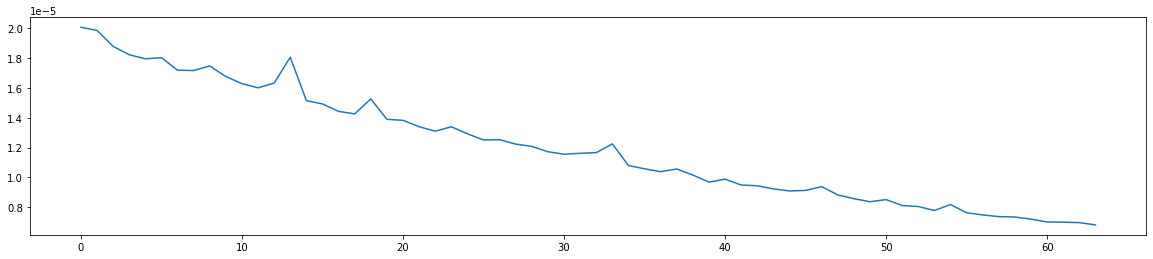

In [81]:
verbose, epochs, batch_size = 0, 64, 64
results = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose)
# evaluate model
_, accuracy = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=0)
plt.figure(figsize=(20,4))
print(accuracy)
plt.plot(results.history['loss'])
plt.show()

In [85]:
threshold = 0.1
predictions = [1 if x >= threshold else 0 for x in model.predict(X_test)]
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

         0.0       0.95      0.93      0.94       213
         1.0       0.93      0.95      0.94       205

    accuracy                           0.94       418
   macro avg       0.94      0.94      0.94       418
weighted avg       0.94      0.94      0.94       418



In [91]:
model.predict_proba(X_test)

array([[9.73822594e-01],
       [1.00000000e+00],
       [1.00000000e+00],
       [1.00000000e+00],
       [1.00000000e+00],
       [1.00000000e+00],
       [1.00000000e+00],
       [9.99999821e-01],
       [1.00000000e+00],
       [8.65319576e-22],
       [1.87521266e-17],
       [2.77198048e-22],
       [4.43433322e-07],
       [1.00000000e+00],
       [1.00000000e+00],
       [1.00000000e+00],
       [9.99996424e-01],
       [1.00000000e+00],
       [1.00000000e+00],
       [1.00000000e+00],
       [1.00000000e+00],
       [1.26442313e-03],
       [1.00000000e+00],
       [1.00000000e+00],
       [1.00000000e+00],
       [1.00000000e+00],
       [1.00000000e+00],
       [1.00000000e+00],
       [1.00000000e+00],
       [9.91281807e-01],
       [5.52242994e-03],
       [2.62065055e-06],
       [7.19549228e-20],
       [4.82188400e-10],
       [1.61546878e-16],
       [6.12084209e-21],
       [4.18234725e-25],
       [2.64758608e-22],
       [8.66113031e-20],
       [5.49036372e-09],


In [77]:
model.save('1d_7period_cnn.h5')

___